# Does Wasserstein-GAN approximate Wasserstein distances?

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AugustinCombes/DeepWasserstein/blob/main/main.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/AugustinCombes/DeepWasserstein/main?labpath=main.ipynb)
[![GitHub](https://badgen.net/badge/icon/github?icon=github&label)](https://github.com/AugustinCombes/DeepWasserstein/blob/main/main.ipynb)

*Group project for the [Optimal Transport course](http://marcocuturi.net/ot.html) at ENSAE teached by Marco Cuturi (spring 2023).*

- Augustin Combes
- Gabriel Watkinson

---

## I. Motivations

The goal of this notebook is to explore whether Wasserstein-GAN (WGAN) can effectively approximate Wasserstein distances. WGAN, introduced in the 2017 [paper](https://arxiv.org/abs/1701.07875) by Arjovsky et al. [1], proposes a neural network-based proxy for the 1-Wasserstein distance, but it is unclear how well this approximation holds up in practice.

To investigate this question, we will implement the WGAN approach to solve Optimal Transport and compare it with other approaches, such as Sinkhorn divergence. Our aim is to determine if WGAN can compute a quantity that is truly similar to “true” optimal transport.

### I.1. Context

The WGAN paper proposes a new approach to learning a probability distribution by leveraging Optimal Transport theory.
Traditionally, learning a probability distribution involves maximizing the likelihood on the data across a family of parametric densities, denoted as $(P_\theta)_{\theta \in \mathbb{R}}$. This is equivalent to minimizing the Kullback-Leibler divergence between the real distribution $\mathbb{P}_r$ and the model distribution $\mathbb{P}_\theta$: $KL(\mathbb{P}_r|| \mathbb{P}_\theta)$. However, in many cases, the model density $P_\theta$ does not exist, and the Kullback-Leibler divergence is undefined.

To remedy to this problem, sampling directly from the target distribution $\mathbb{P}_\theta$ using a generator that maps random noise to a sample from the target distribution is another common approach, most known for its use in the [Variational Auto-Encoder](https://arxiv.org/abs/1312.6114) (VAE) [2] and the [original GAN](https://arxiv.org/abs/1406.2661) [3].

Arjovsky et al. propose a new approach based on Optimal Transport theory, expanding upon the idea of GANs. Traditional GANs are notoriously difficult to train, as a unstable equilibrium between the generator and discriminator is needed, and their results may suffer from mode collapse, in which the generator only produces a few samples that are very similar. WGAN is more stable and easier to tune than traditional GANs, using a proxy to the Wasserstein distance via neural nets. Our aim in this project is to investigate whether WGAN is a promising approach to solving Optimal Transport problems.


> [1]: Arjovsky, Martin, Soumith Chintala, and Léon Bottou. "Wasserstein generative adversarial networks." International conference on machine learning. PMLR, 2017. https://arxiv.org/abs/1701.07875  
> [2]: Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013). https://arxiv.org/abs/1312.6114  
> [3]: Goodfellow, Ian, et al. "Generative adversarial networks." Communications of the ACM 63.11 (2020): 139-144. https://arxiv.org/abs/1406.2661


### I.2. Theory

Unlike in GANs, where the generator's loss is the binary cross-entropy between the discriminator's output and a target value indicating whether the generated sample is real or fake, WGAN use the Wasserstein-1 distance (also known as the Earth Mover's Distance) to measure the difference between the real and generated distributions:

$$
W(\mathbb{P}_r, \mathbb{P}_g) = \inf_{\gamma \in \Pi(\mathbb{P}_r, \mathbb{P}_g)}\mathbb{E}_{(x, y)\sim\gamma}[\vert\vert x-y\vert\vert]
$$
where $\Pi(\mathbb{P}_r, \mathbb{P}_g)$ denotes all joint distributions $\gamma (x,y)$ whose marginals are respectively $\mathbb{P}_r$ and $\mathbb{P}_g$.

However, this formulation is highly impractical, as it is not tractable and can't be used in practice. Instead, WGAN uses the Kantorovich-Rubinstein equivalent:

$$
W(\mathbb{P}_r, \mathbb{P}_\theta) = \sup_{\vert\vert f_L\vert \vert \leq 1}\mathbb{E}_{x_1\sim\mathbb{P}_r}[f(x)] - \mathbb{E}_{x_2\sim\mathbb{P}_\theta}[f(x_2)]
$$

More precisely, we will search $f$ as a parametrized function $f_w$, for $w\in\mathcal{W}$, being $K$-Lipschitz for some $K$. If the supremum is attained for some $w$, then we have a calculation of $W(\mathbb{P}_r, \mathbb{P}_\theta)$ up to a constant factor.

Therefore, to approximate the Wasserstein distance, we will train a neural network to maximize the following objective function:

$$
\max_{w\in\mathcal{W}} \mathbb{E}_{x_1\sim\mathbb{P}_1}[f_w(x_1)] - \mathbb{E}_{x_2\sim\mathbb{P}_2}[f_w(x_2)]
$$

The resulting value should be close to the "true" Wasserstein distance between the two distributions.

### I.3. Numerical estimation

In practice, denoting with $\mathbb{\hat E}$ the empirical mean operator, we will optimize numerically the empirical counterpart of this optimization program, that is:

$$
\max_{w\in\mathcal{W}} \mathbb{\hat E}_{x_1\sim\mathbb{P}_1}[f_w(x_1)] - \mathbb{\hat E}_{x_2\sim\mathbb{P}_2}[f_w(x_2)]
$$

We will estimate the function $f_w$ as an MLP.

Enforcing the 1-Lipschitz constraint can be done using various techniques:

#### I.3.a. Clipping

As proposed in the original WGAN paper, clipping the weights of the network is a simple way to ensure the constraint.

Denoting $l_{w_1}, \dots, l_{w_q}$ as the successive layers of the MLP, such that $f_w = l_{w_1} \circ \dots \circ l_{w_q}$, and using ReLU (1-Lipschitz) activation, a sufficient way of ensuring 1-Lipschitz $f_w$ is to ensure each layer to be 1-Lispchitz.

Then, a sufficient way of ensuring each linear layer $i$ to be 1-Lipschitz is to ensure $\vert\vert w_i\vert\vert_{\infty} \leq 1$. That is, clipping the weights to $[-1, 1]$ ensures the resulting estimate $f_w$ to be 1-Lipschitz.

#### I.3.b. Penalization

As proposed in other follow-up papers, another way to ensure the constraint is to penalize when the parameters do not respect it directly in the loss. 

That is, we then optimize on the following penalized optimization program:

$$\max_{w\in\mathcal{W}} \mathbb{\hat E}_{x_1\sim\mathbb{P}_1}[f_w(x_1)] - \mathbb{\hat E}_{x_2\sim\mathbb{P}_2}[f_w(x_2)] + \lambda\times \vert\vert w - 1(w)\vert\vert _2^2
$$

where $\lambda$ is an additional hyperparameter that controls the amount of penalization given to the constraint, and $1(w)$ is an object of same size than $w$ constant to $1$.

We explore both of these two methods in this notebook.

## II. Packages import

We first import the necessary packages. And install OTT if necessary when running on Google Colab.

In [ ]:
import sys

if "google.colab" in sys.modules:
    print("Running on Colab")
    !pip install -q git+https://github.com/ott-jax/ott@main
else:
    print("Not running on Colab")

In [ ]:
from pathlib import Path

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import requests
import spacy
from bs4 import BeautifulSoup
from jax import grad, jit, vmap
from jax.example_libraries import optimizers, stax
from jax.example_libraries.stax import Dense, Relu
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear.sinkhorn import Sinkhorn
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

image_path = Path("images")
image_path.mkdir(exist_ok=True)

We use [OTT](https://ott-jax.readthedocs.io/en/latest/index.html) to compute the solution to the Optimal Transport problem. 

More generally, we use the [JAX](https://jax.readthedocs.io/en/latest/index.html) library for automatic differentiation and GPU acceleration. From the JAX library, we use the `stax` module that is a small but flexible neural net specification library from scratch. It is meant for examples, if we wanted to train bigger or more sophisticated models, we would use the `flax` library.

## III. Sanity test: compare $\mathcal{N}(0, 1)$ and $\mathcal{N}(1, 1)$

We first run the method on a simple example: comparing the distributions $\mathcal{N}(0, 1)$ and $\mathcal{N}(1, 1)$, with a 2 layer neural network with 32 hidden units.

In [6]:
# Set random seed for reproducibility
key = jax.random.PRNGKey(43)

# 1-dimensional distributions
d = 1

# 2-layers neural net
init_random_params, net = stax.serial(
    Dense(out_dim=32),
    Relu,
    Dense(out_dim=1),
)
_, params = init_random_params(key, (-1, d))

We then define some functions needed to sample the distributions, to compute the loss and to force the weights to be 1-Lipschitz.

In [3]:
# normal sampling & empirical mean
def sample_normal_1d(key, mean, std_dev, num_samples):
    return jax.random.normal(key, (num_samples, 1)) * std_dev + mean


def compute_empirical_mean(params, samples):
    batched_net = vmap(net, in_axes=(None, 0))
    outputs = batched_net(params, samples)
    return outputs.mean()


def sample_two_normals(key):
    m1, s1 = 0, 1  # N(0, 1)
    m2, s2 = 1, 1  # N(1, 1)

    key1, key2 = jax.random.split(key)
    m1, m2, s1, s2 = (
        m1 * jnp.ones(1),
        m2 * jnp.ones(1),
        s1 * jnp.ones(1),
        s2 * jnp.ones(1),
    )
    p1_samples = sample_normal_1d(key1, m1, s1, 512)
    p2_samples = sample_normal_1d(key2, m2, s2, 512)

    return p1_samples, p2_samples


def loss(params, key):
    """
    Samples normal distributions seeded with key, and outputs the estimate of the W1 distance w.r.t params
    """

    p1_samples, p2_samples = sample_two_normals(key)

    loss = compute_empirical_mean(params, p1_samples) - compute_empirical_mean(
        params, p2_samples
    )

    return loss


def clip_weights(params, clip_value=1.0):
    return jax.tree_map(lambda w: jnp.clip(w, -clip_value, clip_value), params)


def pen_loss(params, key, penalty_weight=1e2):
    """
    Penalized loss to enforce the 1-Lipschitz constraint
    """

    objective = loss(params, key)

    pen = 0.0
    weights = params[::2]
    for layer in weights:
        for weight in layer:
            pen += ((1 - jnp.linalg.norm(weight, axis=0, keepdims=True)) ** 2).sum()

    # Add the penalties to the objective with a weight
    total_loss = objective + penalty_weight * pen

    return total_loss

We then run the experiment for 1000 iterations with a learning rate of 0.01.

In [5]:
# Hyperparameters

rms = True  # whether to use rms (True) or gradient descent (False)
pen = True  # whether to use penalization (True) or weight clipping (False)

losses = []
learning_rate = 0.01
num_iterations = 1000

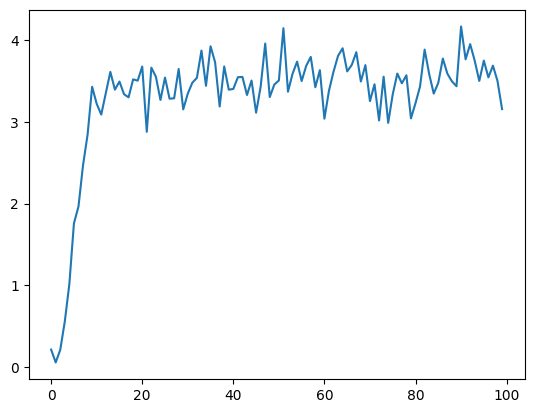

In [6]:
# Training

# Define the gradient function
grad_loss = jit(grad(loss)) if not pen else jit(grad(pen_loss))

if rms:
    opt_init, opt_update, get_params = optimizers.rmsprop(learning_rate)
    opt_state = opt_init(params)

    @jit
    def step(i, opt_state, key):
        params = get_params(opt_state)
        params_grad = grad_loss(params, key)
        return opt_update(i, params_grad, opt_state)


# Optimization loop
for i in range(num_iterations):
    key, subkey = jax.random.split(key)

    if rms:
        opt_state = step(i, opt_state, subkey)
        params = get_params(opt_state)

    else:
        params_grad = grad_loss(params, subkey)
        learning_rate = 1 - i / num_iterations  # linear decrease lr from 1 to 0
        params = jax.tree_map(lambda p, g: p - learning_rate * g, params, params_grad)

    if not pen:
        params = clip_weights(params)

    if i % 10 == 0:
        current_loss = loss(params, subkey)
        losses.append(abs(current_loss.tolist()))
        # print(f"Iteration {i}, Loss: {current_loss:.4f}")

fig, ax = plt.subplots()
ax.plot(np.arange(len(losses)), losses)
ax.set(xlabel="Iteration", ylabel="Loss", title="Loss over iterations")
fig.savefig(str(image_path / "1d_loss_evolution.png"))
plt.show()

We notice that the loss stabilizes around 3.5 after a few iterations.

We then check that the weights are indeed clipped to $[-1, 1]$. We see that the maximum weight is really close to 1, this is good as it shows that the penalization is working as intended.

In [7]:
weights = params[::2]
max_weight = max([jnp.max(jnp.abs(tuple)) for w in weights for tuple in w])
max_weight

Array(1.0054444, dtype=float32)

# IV. Experiment with low-complexity distributions

In [8]:
d = 2
means = np.linspace(-10, 10, 50)
res = np.zeros(shape=(len(means), len(means)))

for idx, mean1 in tqdm(enumerate(means)):
    for idy, mean2 in enumerate(means):
        init_random_params, net = stax.serial(
            Dense(32),
            Relu,
            Dense(1),
        )
        _, params = init_random_params(key, (-1, d))

        def sample_normal(key, mean, std_dev, num_samples, d=2):
            return jax.random.normal(key, (num_samples, d)) * std_dev + mean

        def compute_empirical_mean(params, samples):
            batched_net = vmap(net, in_axes=(None, 0))
            outputs = batched_net(params, samples)
            return outputs.mean()

        def loss(params, key, m2=jnp.array([[mean1, mean2]]), s2=jnp.array([[1, 1]])):
            m1, s1 = jnp.array([[0, 0]]), jnp.array([[1, 1]])

            key1, key2 = jax.random.split(key)
            p1_samples = sample_normal(key1, m1, s1, 512)
            p2_samples = sample_normal(key2, m2, s2, 512)

            return compute_empirical_mean(params, p1_samples) - compute_empirical_mean(
                params, p2_samples
            )

        def clip_weights(params, clip_value=1.0):
            return jax.tree_map(lambda w: jnp.clip(w, -clip_value, clip_value), params)

        def pen_loss(params, key, penalty_weight=1e2):
            objective = loss(params, key)

            # Compute the penalty
            pen = 0.0
            weights = params[::2]
            for layer in weights:
                for weight in layer:
                    pen += (
                        (1 - jnp.linalg.norm(weight, axis=0, keepdims=True)) ** 2
                    ).sum()

            # Add the penalties to the objective with a weight
            total_loss = objective + penalty_weight * pen

            return total_loss

        losses = []
        learning_rate = 0.01
        num_iterations = 500

        # Define the gradient function
        grad_loss = jit(grad(pen_loss))

        opt_init, opt_update, get_params = optimizers.rmsprop(learning_rate)
        opt_state = opt_init(params)

        @jit
        def step(i, opt_state, key):
            params = get_params(opt_state)
            params_grad = grad_loss(params, key)
            return opt_update(i, params_grad, opt_state)

        # Optimization loop
        for i in range(num_iterations):
            key, subkey = jax.random.split(key)

            opt_state = step(i, opt_state, subkey)
            params = get_params(opt_state)

            if i % 10 == 0:
                current_loss = loss(params, subkey)
                losses.append(abs(current_loss.tolist()))

        res[idx, idy] = np.array(losses[15:]).mean()

50it [18:32, 22.25s/it]


In [11]:
res2 = np.zeros(shape=(len(means), len(means)))

mainkey = jax.random.PRNGKey(1)
for idx, mean1 in tqdm(enumerate(means)):
    for idy, mean2 in enumerate(means):

        def sample_normal(key, mean, std_dev, num_samples):
            return jax.random.normal(key, (num_samples, d)) * std_dev + mean

        m1, s1 = jnp.array([[0, 0]]), jnp.array([[1, 1]])
        m2, s2 = jnp.array([[mean1, mean2]]), jnp.array([[1, 1]])

        mainkey, key1, key2 = jax.random.split(mainkey, 3)

        p1_samples = sample_normal(key1, m1, s1, 512)
        p2_samples = sample_normal(key2, m2, s2, 512)

        geom = pointcloud.PointCloud(p1_samples, p2_samples)

        ot_prob = linear_problem.LinearProblem(geom)
        solver = Sinkhorn(norm_error=1)
        ot = solver(ot_prob)

        res2[idx, idy] = ot.reg_ot_cost

50it [00:42,  1.17it/s]


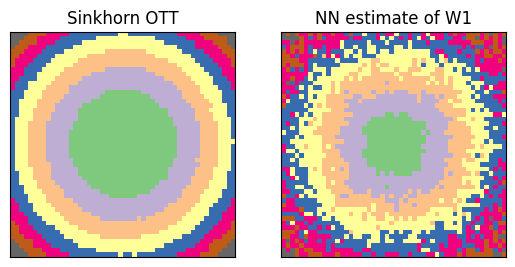

In [13]:
fig, axes = plt.subplots(1, 2)

axes[0].imshow(res2, cmap="Accent")
axes[1].imshow(res, cmap="Accent")

# Set titles for the subplots
axes[0].set(title="Sinkhorn OTT", xticks=[], yticks=[])
axes[1].set(title="NN estimate of W1", xticks=[], yticks=[])
fig.suptitle("Comparaison of W1 and Sinkhorn")
fig.tight_layout()
fig.savefig(str(image_path / "2d_sinkhorn_vs_nn.png"))


# Show the plot
plt.show()

# V. More complex distributions - application to NLP embeddings of synonyms

We will now consider harder distributions to see how the approximation of W1 distance scales both with ambiant distribution dimension and complexity. 

In [31]:
# !pip install spacy
# !pip install beautifulsoup4
# !python -m spacy download fr_core_news_lg

We first select ten French words having diverse meanings and a lot of synonyms

In [198]:
vocabulary = [
    "grand",
    "petit",
    "rapide",
    "lent",
    "beau",
    "triste",
    "content",
    "riche",
    "facile",
    "difficile",
]
vocab_size = len(vocabulary)

We collect words associated with these words, that is, their synonyms.

In [199]:
distributions = dict()
for word in vocabulary:
    url = f"http://www.synonymo.fr/synonyme/{word}"

    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
        synos_list = soup.select("ul.synos > li > a")
        synonyms = [syno.text for syno in synos_list]

        distributions[word] = synonyms
    else:
        print("Scraping error.")

# distributions sizes

dist_sizes = {k: len(v) for k, v in distributions.items()}
print(f"Mean size of the samples: {sum(dist_sizes.values())/10}")

Mean size of the samples: 181.4


We use pretrained high-dimensional embeddings to map these words to 300-dim vectors. We will consider 10 distributions, where each distribution is formed with the synonym embeddings of one of the 10 selected words.

In [200]:
# Load pretrained language model


nlp = spacy.load("fr_core_news_lg")


def get_word_embedding(word):
    token = nlp(word)
    vec = token.vector
    return jnp.array(vec)


distributions = {
    k: jnp.array(list(map(get_word_embedding, v))) for k, v in distributions.items()
}

## V.1. Compute pairwise Sinkhorn OTT distances

In [122]:
# Compute pairwise ott-jax sinkhorn distance

res_words_sinkhorn = np.zeros((vocab_size, vocab_size))

for idx in tqdm(np.arange(vocab_size)):
    for idy in np.arange(vocab_size):
        wordx, wordy = vocabulary[idx], vocabulary[idy]

        embeddingsx = distributions[wordx]
        embeddingsy = distributions[wordy]

        geom = pointcloud.PointCloud(embeddingsx, embeddingsy)

        ot_prob = linear_problem.LinearProblem(geom)
        solver = Sinkhorn(norm_error=1)
        ot = solver(ot_prob)

        res_words_sinkhorn[idx, idy] = ot.reg_ot_cost

100%|██████████| 10/10 [00:58<00:00,  5.87s/it]


## V.2. Compute pairwise W1 NN estimate distances

In [194]:
def sample_from_word(key, word, num_samples):
    card = dist_sizes[word]
    indexs = jax.random.choice(key, jnp.arange(card), shape=(num_samples,))
    return distributions[word][indexs]

In [207]:
# Compute pairwise wgan w1 distance

res_words_nn = np.zeros((vocab_size, vocab_size))

# Set random seed for reproducibility
key = jax.random.PRNGKey(43)

d = 300

# 2-layers neural net
init_random_params, net = stax.serial(
    Dense(32),
    Relu,
    Dense(32),
    Relu,
    Dense(1),
)
_, params = init_random_params(key, (-1, d))


def compute_empirical_mean(params, samples):
    batched_net = vmap(net, in_axes=(None, 0))
    outputs = batched_net(params, samples)
    return outputs.mean()

In [208]:
def loss(params, p1_samples, p2_samples):
    return compute_empirical_mean(params, p1_samples) - compute_empirical_mean(
        params, p2_samples
    )


def pen_loss(params, ind_word_1, ind_word_2, penalty_weight=1e2):
    """
    Penalized loss to enforce the 1-Lipschitz constraint
    """

    objective = loss(params, ind_word_1, ind_word_2)

    pen = 0.0
    weights = params[::2]
    for layer in weights:
        for weight in layer:
            pen += ((1 - jnp.linalg.norm(weight, axis=0, keepdims=True)) ** 2).sum()

    # Add the penalties to the objective with a weight
    total_loss = objective + penalty_weight * pen

    return total_loss

In [209]:
# Training

learning_rate = 0.01
num_iterations = 500

for ind_word_1 in tqdm(range(vocab_size)):
    for ind_word_2 in range(vocab_size):
        losses = []

        # Define the gradient function
        grad_loss = jit(grad(pen_loss))

        opt_init, opt_update, get_params = optimizers.rmsprop(learning_rate)
        opt_state = opt_init(params)

        @jit
        # def step(i, opt_state, key, ind_word_1, ind_word_2):
        def step(i, opt_state, p1, p2):
            params = get_params(opt_state)
            params_grad = grad_loss(params, p1, p2)
            return opt_update(i, params_grad, opt_state)

        # Optimization loop
        for i in range(num_iterations):
            key, subkey = jax.random.split(key)

            word1, word2 = vocabulary[ind_word_1], vocabulary[ind_word_2]

            key1, key2 = jax.random.split(subkey)
            p1_samples = sample_from_word(key1, word1, 32)
            p2_samples = sample_from_word(key2, word2, 32)

            # opt_state = step(i, opt_state, subkey, ind_word_1, ind_word_2)
            opt_state = step(i, opt_state, p1_samples, p2_samples)
            params = get_params(opt_state)

            if i % 10 == 0:
                current_loss = loss(params, p1_samples, p2_samples)
                losses.append(abs(current_loss.tolist()))
                # print(f"Iteration {i}, Loss: {current_loss:.4f}")

        # plt.plot(np.arange(len(losses)), losses)
        res_words_nn[ind_word_1, ind_word_2] = np.array(losses[15:]).mean()

100%|██████████| 10/10 [01:51<00:00, 11.13s/it]


## V.3. Compare the pairwise distances

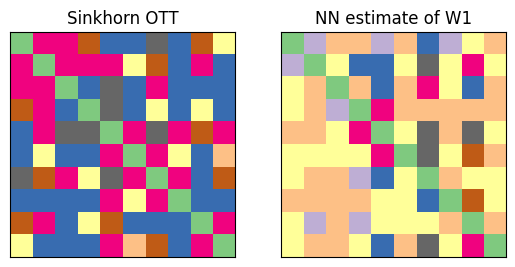

In [202]:
fig, axes = plt.subplots(1, 2)

axes[0].imshow(res_words_sinkhorn, cmap="Accent")
axes[1].imshow(res_words_nn, cmap="Accent")

# Set titles for the subplots
axes[0].set_title("Sinkhorn OTT")
axes[1].set_title("NN estimate of W1")

# Remove axis ticks
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])

# Show the plot
plt.show()

The two matrixes seem to have differing structures. The Sinkhorn pairwise matrix seem to respect better the symetry condition we might expect, as opposed to the NN estimate, where this condition does not seem to be verified. Overall, the results do not look as promising as with the simpler, lower-dimensional normal distributions.

In [175]:
np.corrcoef(res_words_nn.flatten(), res_words_sinkhorn.flatten())[0, 1]

0.7104833186003237

In [172]:
# Train the linear regression model
x, y = res_words_nn.reshape((-1, 1)), res_words_sinkhorn.flatten()

model = LinearRegression()
model.fit(x, y)

# Make predictions
predictions = model.predict(x)

# Print the model coefficients
print("Intercept:", model.intercept_)
print("Slope:", model.coef_[0])

Intercept: 403.28424707738503
Slope: 10.976569956116942


In [174]:
model.score(x, y)

0.5047865460093288